#Maize Plant Leaf **Disease** Detection using Convolution-Neural-Network **(CNN)**


**Extablishing connection between google drive and colab workspace**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls "/content/drive/MyDrive/Projects/data"

ls: cannot access '/content/drive/MyDrive/Projects/data': No such file or directory


In [3]:
!ls "/content/drive/MyDrive/Projects/data/plant"

ls: cannot access '/content/drive/MyDrive/Projects/data/plant': No such file or directory


**Importing Required Libraries**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array,array_to_img
from keras.optimizers import Adam,SGD
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Activation,Flatten,Dropout,Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical

*checking the verion of tensor flow libraires*

In [5]:
print(tf. __version__)

2.14.0


In [6]:
path, dirs, files = next(os.walk('/content/drive/MyDrive/maize/data/plant/Blight'))
file_count = len(files)
print('Number of images for Blight: ', file_count)

path, dirs, files = next(os.walk('/content/drive/MyDrive/maize/data/plant/Common_Rust'))
file_count = len(files)
print('Number of images for Common Rust: ', file_count)

path, dirs, files = next(os.walk('/content/drive/MyDrive/maize/data/plant/Healthy'))
file_count = len(files)
print('Number of images for Healthy leaf: ', file_count)

Number of images for Blight:  1155
Number of images for Common Rust:  1303
Number of images for Healthy leaf:  1162


**Visualising and resizing the Images**

In [7]:
import PIL.Image as Image

def resize_images(path):
  for img_file in os.listdir(path):
    img = Image.open(os.path.join(path, img_file))
    img = img.resize((256, 256))
    img.save(os.path.join(path, img_file))

if __name__ == "__main__":
  directories = ["/content/drive/MyDrive/maize/data/plant/Blight","/content/drive/MyDrive/maize/data/plant/Common_Rust","/content/drive/MyDrive/maize/data/plant/Healthy"]
  for directory in directories:
    resize_images(directory)


# **Blight**

In [8]:
plt.figure(figsize=(12,12))
path="/content/drive/MyDrive/maize/data/plant/Blight"
for i in range(1,17):
  plt.subplot(4,4,i)
  plt.tight_layout()
  rand_img=imread(path+'/'+random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1],fontsize=10)
  plt.ylabel(rand_img.shape[0],fontsize=10)

Output hidden; open in https://colab.research.google.com to view.

# **Common Rust**

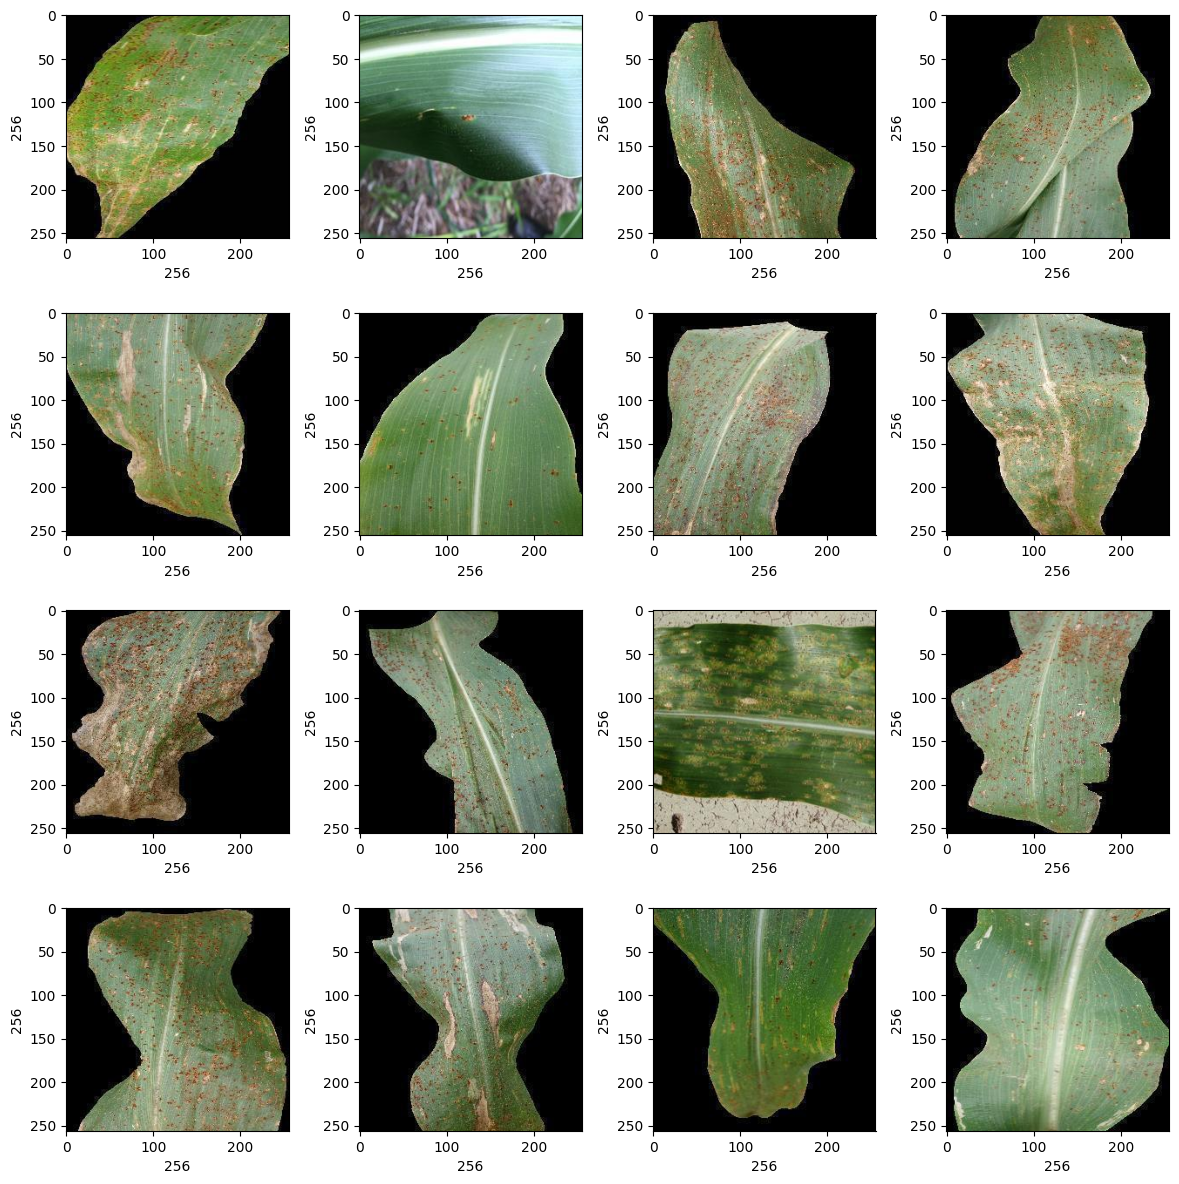

In [9]:
plt.figure(figsize=(12,12))
path="/content/drive/MyDrive/maize/data/plant/Common_Rust"
for i in range(1,17):
  plt.subplot(4,4,i)
  plt.tight_layout()
  rand_img=imread(path+'/'+random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1],fontsize=10)
  plt.ylabel(rand_img.shape[0],fontsize=10)

# **Healthy Leaf**

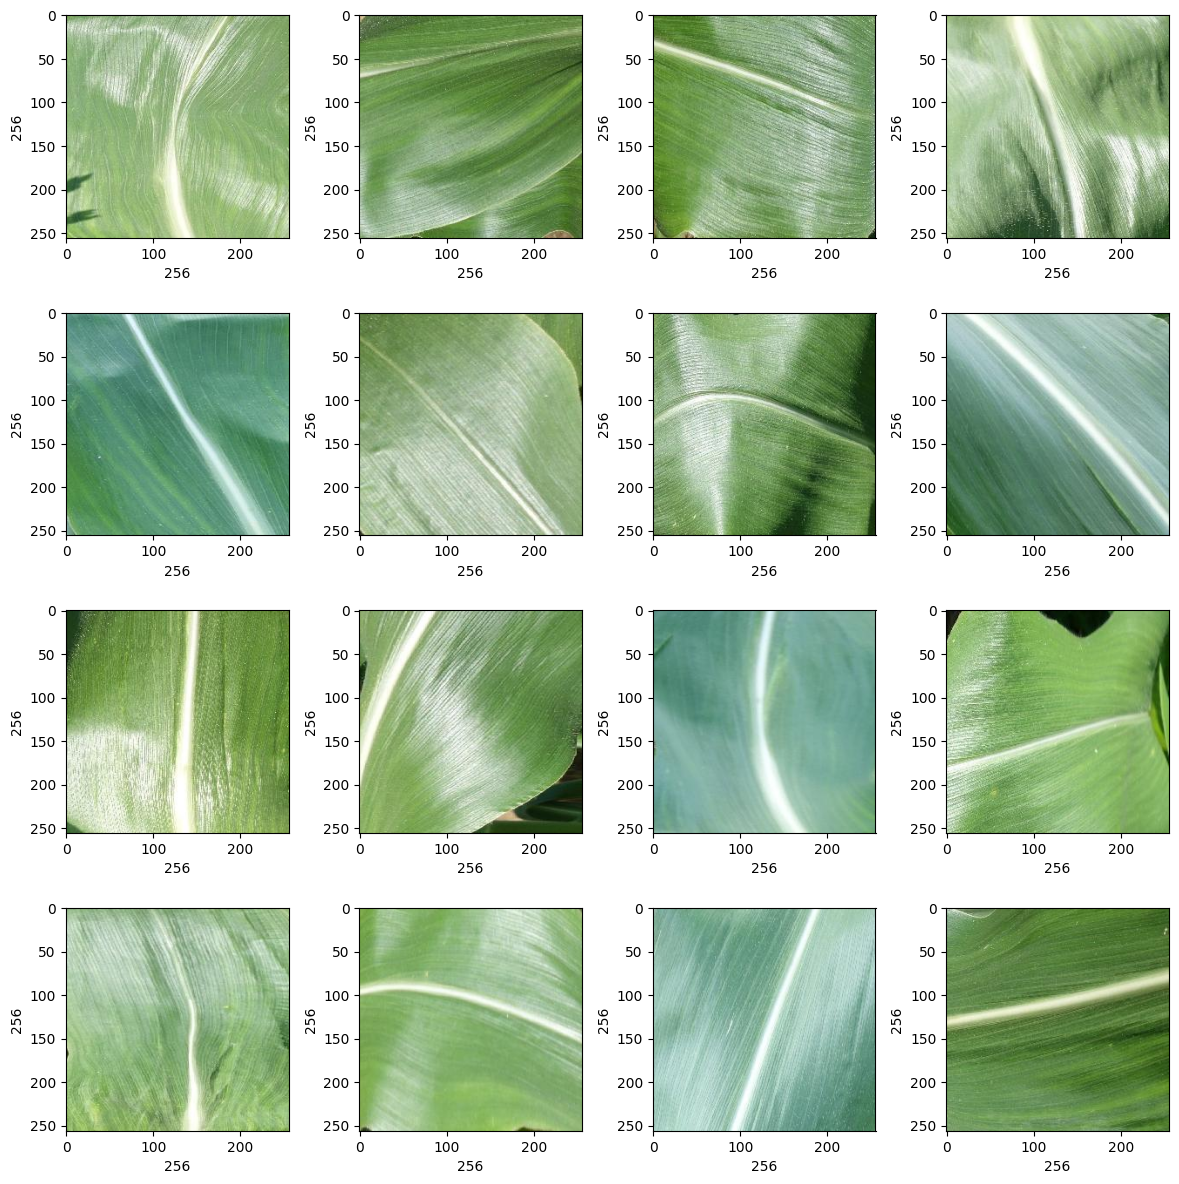

In [10]:
plt.figure(figsize=(12,12))
path="/content/drive/MyDrive/maize/data/plant/Healthy"
for i in range(1,17):
  plt.subplot(4,4,i)
  plt.tight_layout()
  rand_img=imread(path+'/'+random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1],fontsize=10)
  plt.ylabel(rand_img.shape[0],fontsize=10)

**Converting the Images into Numpy Array and Normalize them**

In [11]:
def convert_image_to_array(image_dir):
  try:
    image = cv2.imread(image_dir)
    if image is not None:
      image = cv2.resize(image, (256, 256))
      return img_to_array(image)
    else:
      return np.array([])
  except Exception as e:
    print(f"Error: {e}")
    return None

**Assigning Label**

In [12]:
dir= "/content/drive/MyDrive/maize/data/plant"
image_list,label_list=[],[]
all_labels=['Corn-Blight','Corn-Common_Rust','Corn-Healthy']
binary_labels=[0,1,2]
temp=-1
for directory in ['Blight','Common_Rust','Healthy']:
  plant_image_list=listdir(f"{dir}/{directory}")
  temp+=1
  for files in plant_image_list:
    image_path=f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])

In [13]:
label_counts=pd.DataFrame(label_list).value_counts()
label_counts.head()

1    1303
2    1162
0    1155
dtype: int64


**Blight: 0 : 1155    
Common Rust: 1 : 1303   
Healthty: 2 : 1162**

In [14]:
image_list[0].shape

(256, 256, 3)

**Test-Train split**      
*30% test*  
*70% train*

In [15]:
x_train,x_test,y_train,y_test=train_test_split(image_list,label_list,test_size=0.3,random_state=10)

**Normalising the Images by dividing the each image pixel with 256**

In [16]:
x_train=np.array(x_train,dtype=np.float16)/255.0
x_test=np.array(x_test,dtype=np.float16)/255.0
x_train=x_train.reshape(-1, 256,256,3)
x_test=x_test.reshape(-1, 256,256,3)

**Performing One-Hot Encoding on target Variable**

In [17]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

**Model Building and Compilation**

In [18]:
model=Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="sigmoid"))
model.add(Dense(3, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 42, 42, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 8)                 2

In [19]:
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile( loss = "categorical_crossentropy",
                   optimizer = sgd,
                   metrics=['accuracy']
                 )

*Again spliting the training data-set into training and validation data-set*

In [20]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.3,random_state=10)

In [21]:
epochs=50
batch_size=128
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/50
14/14 [==============================] - 18s 561ms/step - loss: 1.0219 - accuracy: 0.5347 - val_loss: 0.8486 - val_accuracy: 0.6715
Epoch 2/50
14/14 [==============================] - 2s 171ms/step - loss: 0.7367 - accuracy: 0.7236 - val_loss: 0.6177 - val_accuracy: 0.7871
Epoch 3/50
14/14 [==============================] - 2s 166ms/step - loss: 0.6655 - accuracy: 0.7343 - val_loss: 0.5763 - val_accuracy: 0.8042
Epoch 4/50
14/14 [==============================] - 2s 152ms/step - loss: 0.5538 - accuracy: 0.8060 - val_loss: 0.5079 - val_accuracy: 0.8357
Epoch 5/50
14/14 [==============================] - 2s 150ms/step - loss: 0.5228 - accuracy: 0.8082 - val_loss: 0.5886 - val_accuracy: 0.7451
Epoch 6/50
14/14 [==============================] - 3s 219ms/step - loss: 0.4790 - accuracy: 0.8268 - val_loss: 0.4555 - val_accuracy: 0.8463
Epoch 7/50
14/14 [==============================] - 3s 192ms/step - loss: 0.3783 - accuracy: 0.8911 - val_loss: 0.3415 - val_accuracy: 0.9133
Epoch

In [22]:
model.save("/content/drive/MyDrive/maize/data/plant_disease_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


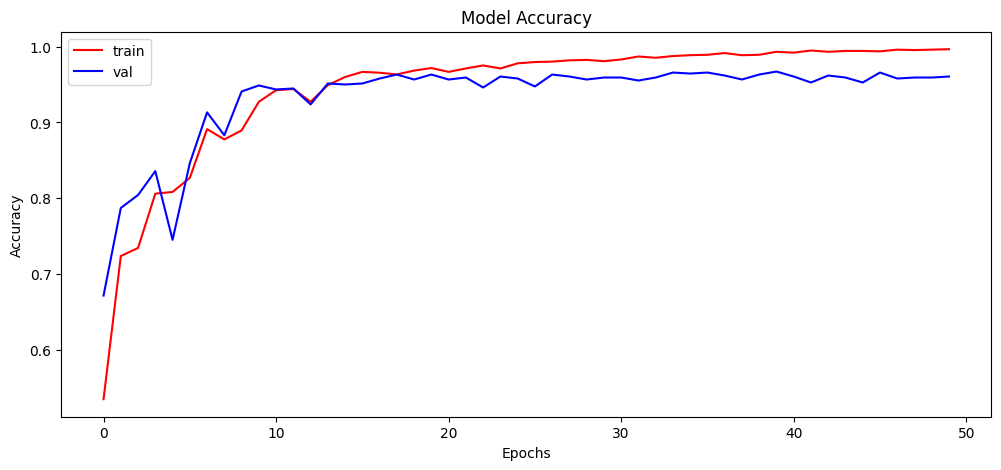

In [23]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])

plt.show()

In [24]:
print("Calculating model accuracy")
scores=model.evaluate(x_test,y_test)
print(f"Test Accuracy: {scores[1]*100} %")

Calculating model accuracy
34/34 [==============================] - 1s 23ms/step - loss: 0.1691 - accuracy: 0.9401
Test Accuracy: 94.0147340297699 %


In [ ]:
y_pred=model.predict(x_test)

In [ ]:
img=array_to_img(x_test[11])
img

In [ ]:
print("Original Label: ",all_labels[np.argmax(y_test[4])])
print("Predicted Label: ",all_labels[np.argmax(y_pred[4])])
print(y_pred[4])

In [ ]:
for i in range(50):
  print(all_labels[np.argmax(y_test[i])]," ",all_labels[np.argmax(y_pred[i])])